In [7]:
import torch
import json

In [224]:
from datetime import datetime
from pathlib import Path
import pygit2

def my_checkout(repo, commit):
    # Reset index and working directory to the target commit
    repo.reset(commit.id, pygit2.GIT_RESET_HARD)
    # Perform the forced checkout
    repo.checkout_tree(commit.tree, strategy=pygit2.GIT_CHECKOUT_FORCE)
    # Update HEAD to point to the new commit
    repo.set_head(commit.id)

repo_name = "requests"

repo_path = Path('Repos',repo_name, "code")
if not repo_path.exists():
    raise ValueError(f"Directory {repo_path} does not exist")

repo = pygit2.Repository(repo_path)
main_branch = repo.branches['main']
walker = repo.walk(main_branch.peel().id, pygit2.GIT_SORT_TIME | pygit2.GIT_SORT_TOPOLOGICAL | pygit2.GIT_SORT_REVERSE)

previous_commit = next(walker)
for commit in walker:
    # check that they are in cronomogical order
    print(f"Processing commit {commit.id} (at {datetime.fromtimestamp(commit.commit_time)})")
    # check that the parent is the previous commit
    if previous_commit not in commit.parents:
        print(f"Parent of commit {commit.id} (at {datetime.fromtimestamp(commit.commit_time)}) is not the previous commit {previous_commit.id} (at {datetime.fromtimestamp(previous_commit.commit_time)}), but {commit.parents[0].id} (at {datetime.fromtimestamp(commit.parents[0].commit_time)})!")
    previous_commit = commit

Processing commit d0bf5538097cbdee663eddf4e29e9f34106c67cb (at 2011-02-13 19:52:30)
Processing commit 0477018761c67152cdcc0b83d56f27e701e65b9e (at 2011-02-13 19:52:37)
Processing commit 75b499dd046060021db0c7a772dd34df9374a30b (at 2011-02-13 19:52:47)
Processing commit c51b44d96bb460ebea3daee7deeff6b686585087 (at 2011-02-13 19:53:01)
Processing commit 72e99c0f49823a5b798f8d15896480b7216c4fba (at 2011-02-13 19:53:08)
Processing commit ffdbc387ea67398ac123b2ff5a5d69df3e198340 (at 2011-02-13 19:53:15)
Processing commit 853a4fd04ce3f4644e204418ee2cd694d9f29180 (at 2011-02-13 19:53:25)
Processing commit a6ffd97ef150f50eb1a0e0e54edf217831011753 (at 2011-02-13 19:56:54)
Processing commit 45c6897128c1e20a98cf259101067123a4768793 (at 2011-02-13 21:08:32)
Processing commit 23842865e973f9aacd58fa935f1fec5c2069de11 (at 2011-02-13 21:10:54)
Processing commit b079a4e03e1a07ce0dd10a3b17d795c9452c9691 (at 2011-02-13 21:47:00)
Processing commit c840bc7d0962d253afd4c8a72c242cbf2b882dc0 (at 2011-02-13 21

In [8]:
from torch.utils.data import Dataset
from transformers import RobertaTokenizer

class CodeTestDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = f"Code Context:\n{item['code_context']}\n\nTarget Line:\n{item['target_line']}\n\nVariable Values:\n" + \
               '\n'.join([f"{k} = {v}" for k, v in item['variable_values'].items()])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        label = 1 if item['label'] == "Sufficiently Tested" else 0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [9]:
# test getting blob content without checking out

from pathlib import Path
import pygit2

commit_str = '80a790443e693d982296db93ceebc9135b6efb9c'

file_path = Path('Repos')/'requests'/'code'/'tests'/'test_utils.py'

repo_path = Path('Repos',"requests", "code")
repo = pygit2.Repository(repo_path)

commit = repo.get(commit_str)

file_entry = commit.tree[file_path.relative_to(repo_path).as_posix()]
file_content = repo.get(file_entry.id).data.decode("utf-8")

print(file_content.splitlines()[:10])

['# -*- coding: utf-8 -*-', '', 'import os', 'import copy', 'import filecmp', 'from io import BytesIO', 'import zipfile', 'from collections import deque', '', 'import pytest']


In [38]:
import re

regex = re.compile(r" at 0x[0-9A-F]{16}(?=>|$)")

regex.sub("","<function Response.iter_content.<locals>.generate at 0x0000023E84745AF0>")

'<function Response.iter_content.<locals>.generate>'

In [115]:
def count_combinations(df):
    return df.drop_duplicates().shape[0]

# I want the longest string under threshold.
# so as long as both are valid, I should keep the longer one.
def get_combinations(selected, remaining, df, threshold):
    if len(remaining) == 0:
        return selected
    else:
        res = get_combinations(selected, remaining[1:], df, threshold)
        candidate = selected + [remaining[0]]
        if count_combinations(df[candidate]) <= threshold:
            option_B = get_combinations(selected + [remaining[0]], remaining[1:], df, threshold)
            if len(option_B) > len(res):
                res = option_B
        return res
        

In [175]:

import numpy as np
import pandas as pd

#remove anything that looks like an adress before the end of the string or >
remove_address = re.compile(r" at 0x[0-9A-F]{16}(?=>|$)")

def compress_variables(variable_histories):
    df = pd.DataFrame(variable_histories)    

    # remove addresses, to create more duplicates
    # do not replace missing numbers with the string "nan"...
    df = df.map(lambda x: remove_address.sub("", x) if pd.notna(x) else x)

    # Drop columns with constant values
    df = df.loc[:, (df != df.iloc[0]).any()]

    # Remove duplicate rows
    df = df.drop_duplicates()

    # Identify long repeating values and replace with placeholders
    placeholder_dict = {}
    long_threshold = 12
    occurrences_threshold = 3
    for col in df.columns:
        # Find long values that occur repeatedly
        long_values = df[col][df[col].str.len() > long_threshold].value_counts()
        repeating_values = long_values[long_values > occurrences_threshold]

        for value in repeating_values.index:
            placeholder = f"var#{len(placeholder_dict) + 1}"
            placeholder_dict[placeholder] = value
            df[col] = df[col].replace(value, placeholder)

    # Find columns with few unique values
    threshold = 10  # Maximum number of unique combinations allowed

    group_columns = get_combinations([], df.columns, df, threshold)
    # print(group_columns)
    if not group_columns:
        # convert to string
        res = ""
        if placeholder_dict:
            res += "Placeholders:\n" + '\n'.join([ f"{k} = {v}" for k, v in placeholder_dict.items()])
        res +="\nVariable Histories:\n"
        for i, row in df.iterrows():
            res += ' | '.join([f"{k} = {v}" for k, v in row.items() if pd.notna(v)]) + "\n"
        return res
    
    df_sorted = df.sort_values(by=group_columns).reset_index(drop=True)

    grouped = df_sorted.groupby(group_columns)

    # Prepare the formatted output
    formatted_output = ""
    
    if placeholder_dict:
        formatted_output += "Placeholders:\n" + '\n'.join([ f"{k} = {v}" for k, v in placeholder_dict.items()])
    formatted_output +="\nVariable Histories:\n"
    for group_values, group_df in grouped:
        # print the number of the group and the number of rows in the group
        # print(f"Group {group_values} ({group_df.shape[0]} rows)")
        # Extract the common variables
        common_vars = ' | '.join([f"{col} = {val}" for col, val in zip(group_columns, group_values)])
        formatted_output += f"{common_vars}\n"
        
        # Format the varying variables
        for idx, row in group_df.iterrows():
            # Exclude the group columns from the row
            varying_vars = {col: row[col] for col in df.columns if col not in group_columns}
            if varying_vars:
                # Convert varying variables to a string
                varying_vars_str = ' | '.join([f"{k} = {v}" for k, v in varying_vars.items()])
                formatted_output += f"- {varying_vars_str}\n"
    
    return formatted_output


def make_text(item) -> str:
    variables = item['variable_histories']
    compressed_variables = compress_variables(variables)

    return (
        f"Code Context:\n" +
        item['code_context'] +
        "\n\nTarget Line:\n" +
        item['target_line'] +
        compressed_variables
    )

In [172]:
make_text(data[38342])

['response']
Group ('<Response [204]>',) (1 rows)
Group ('<Response [301]>',) (3 rows)
Group ('<Response [302]>',) (3 rows)
Group ('<Response [303]>',) (2 rows)
Group ('<Response [307]>',) (1 rows)
Group ('<Response [401]>',) (1 rows)
Group ('<Response [404]>',) (1 rows)
Group ('<Response [500]>',) (1 rows)
Group ('var#4',) (4 rows)


'Code Context:\n            conn.cert_reqs = "CERT_NONE"\n            conn.ca_certs = None\n            conn.ca_cert_dir = None\n\n        if cert:\n            if not isinstance(cert, basestring):\n                conn.cert_file = cert[0]\n                conn.key_file = cert[1]\n            else:\n                conn.cert_file = cert\n                conn.key_file = None\n\nTarget Line:\nif not isinstance(cert, basestring):Placeholders:\nvar#1 = <PreparedRequest [GET]>\nvar#2 = <PreparedRequest [POST]>\nvar#3 = <PreparedRequest [HEAD]>\nvar#4 = <Response [200]>\nVariable Histories:\nresponse = <Response [204]>\n- req = var#1\nresponse = <Response [301]>\n- req = var#3\n- req = var#2\n- req = var#1\nresponse = <Response [302]>\n- req = var#2\n- req = var#3\n- req = var#1\nresponse = <Response [303]>\n- req = var#2\n- req = var#3\nresponse = <Response [307]>\n- req = var#2\nresponse = <Response [401]>\n- req = var#1\nresponse = <Response [404]>\n- req = var#1\nresponse = <Response [50

In [223]:
a = [3, 4, 5, 6]
a.append(7)
a.pop(-1)
a

[3, 4, 5, 6]

In [ ]:
a = []

In [210]:
from typing import Tuple
import pygit2
from torch.utils.data import Dataset
from transformers import RobertaTokenizer
import torch
from pathlib import Path
import json

def get_code_context(file_content, target_line, window_size=5) -> Tuple[str, str]:
    lines = file_content.splitlines()

    start = max(target_line - window_size - 1, 0)
    end = min(target_line + window_size, len(lines))
    context = '\n'.join(lines[start:end])
    assert target_line <= len(lines), f"Target line {target_line} is out of range for file with length {len(lines)}"
    target_line = min(target_line, len(lines))
    target = lines[target_line - 1].strip()
    return context, target

def next_commit(repo, commit):
     return next(repo.walk(commit.id, pygit2.GIT_SORT_TOPOLOGCAL | pygit2.GIT_SORT_REVERSE))

def process_file(label, repo, absolute_repo_path, commit, record_file_path):
    try:
        with open(record_file_path, "r") as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"File {record_file_path} not found")
        pass
    res = []
    for file_path, lines in data.items():
        relative_file_path = Path(file_path).relative_to(absolute_repo_path).as_posix()
        file_entry = commit.tree[relative_file_path]
        file_content = repo.get(file_entry.id).data.decode("utf-8")
        for line_num, tried_variables in lines.items():
            context, target = get_code_context(file_content, int(line_num), window_size=5)
            data_point = {
                "code_context": context,
                "target_line": target,
                "variable_histories": tried_variables,
                "label": label
            }
            res.append(data_point)
    return res

def load_data(data_path: Path):
    res = []

    for repo_name in data_path.iterdir():
        repo_path = Path('Repos',repo_name.name, "code")
        absolute_repo_path = repo_path.absolute()
        repo = pygit2.Repository(repo_path)
        for commit_dir in repo_name.iterdir():
            commit = repo.get(commit_dir.name)
            negative_data = process_file(0, repo, absolute_repo_path, commit, commit_dir / "negative_example.json")
            positive_data = process_file(1, repo, absolute_repo_path, next_commit(repo, commit), commit_dir / "positive_example.json")
            res.extend(negative_data)
            res.extend(positive_data)
    return res

class CodeTestDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length=512):
        self.data = load_data(Path(data_path))
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = make_text(item)
                                                                               
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(item["label"], dtype=torch.long)
        }


In [211]:
import time

start_load = time.time()
data = load_data(Path("data"))
print(f"Load time: {time.time() - start_load}")

AttributeError: module 'pygit2' has no attribute 'GIT_SORT_TOPOLOGCAL'

In [176]:
import time
import numpy as np
from transformers import RobertaTokenizerFast

too_long = 0
data_parsed= {}
length = []
text_time = []
enc_time = []

tokenizer = RobertaTokenizerFast.from_pretrained('microsoft/codebert-base')

for i, item in enumerate(data):
    start = time.time()
    text = make_text(item)
    mid = time.time()
    encoding = tokenizer(
            text,
            truncation=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
    end = time.time()
    enclen = len(encoding['input_ids'].flatten())
    length.append(enclen)
    data_parsed[enclen] = text
    text_time.append(mid - start)
    enc_time.append(end - mid)
    if enclen > 512:
        too_long += 1

    if i % 100 == 0:
        print(f"{too_long} too long out of {i}")
        print(f"Average length: {np.mean(length)}")
        print(f"Average text time: {np.mean(text_time)}")
        print(f"Average encoding time: {np.mean(enc_time)}")
    

Token indices sequence length is longer than the specified maximum sequence length for this model (1460 > 512). Running this sequence through the model will result in indexing errors


0 too long out of 0
Average length: 240.0
Average text time: 0.004433870315551758
Average encoding time: 0.0
33 too long out of 100
Average length: 1875.6039603960396
Average text time: 0.0047656970449013285
Average encoding time: 0.0023965646724889776
78 too long out of 200
Average length: 2120.3283582089553
Average text time: 0.020053998747868323
Average encoding time: 0.002829395123382113
102 too long out of 300
Average length: 1811.2691029900332
Average text time: 0.02013749933718051
Average encoding time: 0.002446417000602646
110 too long out of 400
Average length: 1438.1920199501246
Average text time: 0.01907720946314329
Average encoding time: 0.0019836485237254764
154 too long out of 500
Average length: 1823.870259481038
Average text time: 0.017186980523511083
Average encoding time: 0.0024417593569574718
188 too long out of 600
Average length: 1787.8485856905158
Average text time: 0.02231232378129753
Average encoding time: 0.0023986499837154954
192 too long out of 700
Average le

KeyboardInterrupt: 

In [24]:
print(data_parsed[max(data_parsed.keys())])

Code Context:
        # non-ASCII characters. This allows users to automatically get the correct IDNA
        # behaviour. For strings containing only ASCII characters, we need to also verify
        # it doesn't start with a wildcard (*), before allowing the unencoded hostname.
        if not unicode_is_ascii(host):
            try:
                host = self._get_idna_encoded_host(host)
            except UnicodeError:
                raise InvalidURL('URL has an invalid label.')
        elif host.startswith((u'*', u'.')):
            raise InvalidURL('URL has an invalid label.')


Target Line:
host = self._get_idna_encoded_host(host)

Variable Histories:
self: <PreparedRequest [GET]> url: 'https://www.python.org' params: OrderedDict() scheme: 'https' auth: None host: 'www.python.org' port: None path: '/' query: None fragment: None netloc: 'www.python.org'
self: <PreparedRequest [GET]> url: 'http://httpbin.org/get' params: OrderedDict() scheme: 'http' auth: None host: 'httpbin.org' 

In [21]:
data[0]

{'code_context': '    from .models import PreparedRequest\n\n\nDEFAULT_POOLBLOCK = False\nDEFAULT_POOLSIZE = 10\nDEFAULT_RETRIES = 0\nDEFAULT_POOL_TIMEOUT = None\n\n\ntry:\n    import ssl  # noqa: F401',
 'target_line': 'DEFAULT_RETRIES = 0',
 'variable_histories': [{'self': '<partially initialized object>',
   '__class__': "<class 'requests.adapters.BaseAdapter'>"},
  {'self': '<partially initialized object>',
   '__class__': "<class 'requests.adapters.BaseAdapter'>"},
  {'self': '<partially initialized object>',
   '__class__': "<class 'requests.adapters.BaseAdapter'>"},
  {'self': '<partially initialized object>',
   '__class__': "<class 'requests.adapters.BaseAdapter'>"},
  {'self': '<partially initialized object>',
   '__class__': "<class 'requests.adapters.BaseAdapter'>"},
  {'self': '<partially initialized object>',
   '__class__': "<class 'requests.adapters.BaseAdapter'>"},
  {'self': '<partially initialized object>',
   '__class__': "<class 'requests.adapters.BaseAdapter'>"},


In [6]:
len(data)

79306

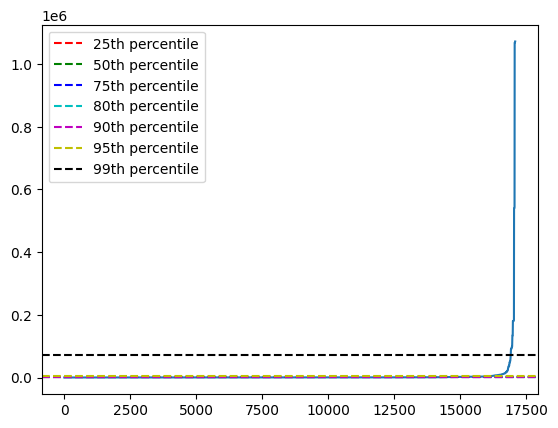

[0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]
[  212.    266.    507.    691.   1979.   5190.  70938.4]


In [177]:
from matplotlib import pyplot as plt

plt.plot(sorted(length))

quantiles = np.quantile(length, [0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99])
plt.axhline(y=quantiles[0], color='r', linestyle='--', label='25th percentile')
plt.axhline(y=quantiles[1], color='g', linestyle='--', label='50th percentile')
plt.axhline(y=quantiles[2], color='b', linestyle='--', label='75th percentile')
plt.axhline(y=quantiles[3], color='c', linestyle='--', label='80th percentile')
plt.axhline(y=quantiles[4], color='m', linestyle='--', label='90th percentile')
plt.axhline(y=quantiles[5], color='y', linestyle='--', label='95th percentile')
plt.axhline(y=quantiles[6], color='k', linestyle='--', label='99th percentile')
plt.legend()
plt.show()

print([0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99])
print(quantiles)

In [179]:
import json
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, random_split

data_path = Path('data')

tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
dataset = CodeTestDataset(data_path, tokenizer)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [180]:
label_count = {0: 0, 1: 0}

for i, data in enumerate(train_dataset):
    if i % 1000 == 0:
        print(f"{i}: {label_count}")
    labels = data['labels']
    label_count[labels.item()] += 1

0: {0: 0, 1: 0}
1000: {0: 480, 1: 520}


KeyboardInterrupt: 

In [ ]:
unique_labels, counts = np.unique(train_labels, return_counts=True)

In [51]:
np.unique([val["labels"] for val in train_dataset], return_counts=True)


KeyboardInterrupt: 

In [186]:
from transformers import RobertaModel
import torch.nn as nn

class CodeClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CodeClassifier, self).__init__()
        self.model = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


In [13]:
from transformers import RobertaModel, RobertaConfig
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

class CodeClassifierWithLoRA(nn.Module):
    def __init__(self, num_labels):
        super(CodeClassifierWithLoRA, self).__init__()
        self.config = RobertaConfig.from_pretrained('microsoft/codebert-base')
        self.model = RobertaModel.from_pretrained('microsoft/codebert-base', config=self.config)
        
        # Define LoRA configuration
        lora_config = LoraConfig(
            task_type= TaskType.FEATURE_EXTRACTION,   # Sequence classification task
            inference_mode=False,
            r=8,                          # Rank of the adapters
            lora_alpha=32,                # Scaling factor
            lora_dropout=0.1,             # Dropout for LoRA
            target_modules=supported_module_names
        )
        
        # Apply LoRA to the model
        self.model = get_peft_model(self.model, lora_config)
        
        # Classification head
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [196]:
from transformers import RobertaConfig, RobertaForSequenceClassification
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

class CodeClassifierWithLoRA_classifier(nn.Module):
    def __init__(self, num_labels):
        super(CodeClassifierWithLoRA_classifier, self).__init__()
        base_config =  RobertaConfig.from_pretrained('microsoft/codebert-base', num_labels=2)
        base_model =  RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', config=base_config)
        
        supported_types = (nn.Linear, nn.Embedding, nn.Conv2d, nn.Conv1d)
        supported_module_names = [ name for name, module in base_model.named_modules() if isinstance(module, supported_types)]

        # Define LoRA configuration
        lora_config = LoraConfig(
            task_type= TaskType.SEQ_CLS,   # Sequence classification task
            inference_mode=False,
            r=8,                          # Rank of the adapters
            lora_alpha=32,                # Scaling factor
            lora_dropout=0.1,             # Dropout for LoRA
            target_modules=supported_module_names
        )
        
        # Apply LoRA to the model
        self.model = get_peft_model(base_model, lora_config)
        
        # Classification head
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        # Extract logits directly (RobertaForSequenceClassification provides them)
        logits = outputs.logits
        
        # If labels are provided, return both loss and logits
        if labels is not None:
            return outputs.loss, logits  # Outputs.loss is automatically calculated if labels are given
        
        return logits

In [64]:
import torch

torch.cuda.is_available()

True

In [8]:
print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24575MB, multi_processor_count=82, uuid=3ed31541-bac9-7b7c-43cf-ce4dd8819fdd, L2_cache_size=6MB)


In [ ]:
import torch
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from tqdm import tqdm

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize model, optimizer, and loss function
model_c = CodeClassifier(num_labels=2)
model_c = model_c.to(device)
optimizer = AdamW(model_c.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()
num_epochs = 1000

# Training Loop
for epoch in range(num_epochs):
    model_c.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model_c(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss}")
    
    # Validation
    model_c.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model_c(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")


c:\Users\franc\Documents\ETH\Project\.conda\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 3966/3966 [1:02:42<00:00,  1.05it/s]


Average Training Loss: 0.00022951173756516425


Validation: 100%|██████████| 992/992 [10:25<00:00,  1.59it/s]


Validation Accuracy: 1.0000


Training Epoch 2:   4%|▍         | 155/3966 [02:35<1:03:53,  1.01s/it]


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch
import json
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from peft import LoraConfig, TaskType, get_peft_model
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

# Initialize model
model = CodeClassifierWithLoRA(num_labels=2)
model = model.to(device)

# Freeze base model parameters if not already handled by peft
for name, param in model.named_parameters():
    param.requires_grad = ('lora_' in name)

# Verify trainable parameters
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Number of trainable parameters: {len(trainable_params)}")

# Define optimizer (only train LoRA adapter parameters)
optimizer = AdamW(model.parameters(), lr=2e-4)  # LoRA typically uses a higher learning rate

# Define loss function
loss_fn = CrossEntropyLoss()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
    
        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
    
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Epoch {epoch+1} - Validation Accuracy: {accuracy:.4f}")


Device: cuda


c:\Users\franc\Documents\ETH\Project\.conda\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Number of trainable parameters: 152


Training Epoch 1: 100%|██████████| 3966/3966 [1:02:45<00:00,  1.05it/s]


Epoch 1 - Average Training Loss: 0.0010


Validation: 100%|██████████| 992/992 [11:21<00:00,  1.46it/s]


Epoch 1 - Validation Accuracy: 1.0000


Training Epoch 2: 100%|██████████| 3966/3966 [1:02:27<00:00,  1.06it/s]


Epoch 2 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:21<00:00,  1.46it/s]


Epoch 2 - Validation Accuracy: 1.0000


Training Epoch 3: 100%|██████████| 3966/3966 [1:02:28<00:00,  1.06it/s]


Epoch 3 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:21<00:00,  1.46it/s]


Epoch 3 - Validation Accuracy: 1.0000


Training Epoch 4: 100%|██████████| 3966/3966 [1:02:21<00:00,  1.06it/s]


Epoch 4 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:20<00:00,  1.46it/s]


Epoch 4 - Validation Accuracy: 1.0000


Training Epoch 5: 100%|██████████| 3966/3966 [1:02:29<00:00,  1.06it/s]


Epoch 5 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:20<00:00,  1.46it/s]


Epoch 5 - Validation Accuracy: 1.0000


Training Epoch 6: 100%|██████████| 3966/3966 [1:02:22<00:00,  1.06it/s]


Epoch 6 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:19<00:00,  1.46it/s]


Epoch 6 - Validation Accuracy: 1.0000


Training Epoch 7: 100%|██████████| 3966/3966 [1:02:23<00:00,  1.06it/s]


Epoch 7 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:21<00:00,  1.46it/s]


Epoch 7 - Validation Accuracy: 1.0000


Training Epoch 8: 100%|██████████| 3966/3966 [1:02:25<00:00,  1.06it/s]


Epoch 8 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:17<00:00,  1.46it/s]


Epoch 8 - Validation Accuracy: 1.0000


Training Epoch 9: 100%|██████████| 3966/3966 [1:02:29<00:00,  1.06it/s]


Epoch 9 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:33<00:00,  1.43it/s]


Epoch 9 - Validation Accuracy: 1.0000


Training Epoch 10: 100%|██████████| 3966/3966 [1:05:07<00:00,  1.02it/s]


Epoch 10 - Average Training Loss: 0.0000


Validation: 100%|██████████| 992/992 [11:36<00:00,  1.42it/s]

Epoch 10 - Validation Accuracy: 1.0000


In [197]:
import torch
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

# Initialize model
model_c = CodeClassifierWithLoRA_classifier(num_labels=2)
model_c = model_c.to(device)

# Freeze base model parameters if not already handled by peft
for name, param in model_c.named_parameters():
    print("considering layer: ", name)
    param.requires_grad = ('lora_' in name) or ('classifier' in name)

# Verify trainable parameters
trainable_params = [p for p in model_c.parameters() if p.requires_grad]
print(f"Number of trainable parameters: {len(trainable_params)}")

# Define optimizer (only train LoRA adapter parameters)
optimizer = AdamW(model_c.parameters(), lr=2e-4)  # LoRA typically uses a higher learning rate

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model_c.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
    
        optimizer.zero_grad()
        loss, logits = model_c(input_ids=input_ids, attention_mask=attention_mask, labels = labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")
    
    # Validation
    model_c.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
    
            logits = model_c(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Epoch {epoch+1} - Validation Accuracy: {accuracy:.4f}")


Device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


considering layer:  model.base_model.model.roberta.embeddings.word_embeddings.base_layer.weight
considering layer:  model.base_model.model.roberta.embeddings.word_embeddings.lora_embedding_A.default
considering layer:  model.base_model.model.roberta.embeddings.word_embeddings.lora_embedding_B.default
considering layer:  model.base_model.model.roberta.embeddings.position_embeddings.base_layer.weight
considering layer:  model.base_model.model.roberta.embeddings.position_embeddings.lora_embedding_A.default
considering layer:  model.base_model.model.roberta.embeddings.position_embeddings.lora_embedding_B.default
considering layer:  model.base_model.model.roberta.embeddings.token_type_embeddings.base_layer.weight
considering layer:  model.base_model.model.roberta.embeddings.token_type_embeddings.lora_embedding_A.default
considering layer:  model.base_model.model.roberta.embeddings.token_type_embeddings.lora_embedding_B.default
considering layer:  model.base_model.model.roberta.embeddings.La

Training Epoch 1: 100%|██████████| 3966/3966 [1:10:41<00:00,  1.07s/it]


Epoch 1 - Average Training Loss: 0.6974


Validation: 100%|██████████| 992/992 [13:46<00:00,  1.20it/s]


Epoch 1 - Validation Accuracy: 0.4997


Training Epoch 2: 100%|██████████| 3966/3966 [1:10:45<00:00,  1.07s/it]


Epoch 2 - Average Training Loss: 0.6945


Validation: 100%|██████████| 992/992 [13:49<00:00,  1.20it/s]


Epoch 2 - Validation Accuracy: 0.5003


Training Epoch 3: 100%|██████████| 3966/3966 [1:10:32<00:00,  1.07s/it]


Epoch 3 - Average Training Loss: 0.6943


Validation: 100%|██████████| 992/992 [13:47<00:00,  1.20it/s]


Epoch 3 - Validation Accuracy: 0.5003


Training Epoch 4: 100%|██████████| 3966/3966 [1:10:27<00:00,  1.07s/it]


Epoch 4 - Average Training Loss: 0.6942


Validation: 100%|██████████| 992/992 [13:43<00:00,  1.20it/s]


Epoch 4 - Validation Accuracy: 0.4997


Training Epoch 5: 100%|██████████| 3966/3966 [1:10:25<00:00,  1.07s/it]


Epoch 5 - Average Training Loss: 0.6941


Validation: 100%|██████████| 992/992 [13:41<00:00,  1.21it/s]


Epoch 5 - Validation Accuracy: 0.5003


Training Epoch 6: 100%|██████████| 3966/3966 [1:10:18<00:00,  1.06s/it]


Epoch 6 - Average Training Loss: 0.6941


Validation: 100%|██████████| 992/992 [13:46<00:00,  1.20it/s]


Epoch 6 - Validation Accuracy: 0.5003


Training Epoch 7: 100%|██████████| 3966/3966 [1:10:18<00:00,  1.06s/it]


Epoch 7 - Average Training Loss: 0.6941


Validation: 100%|██████████| 992/992 [13:44<00:00,  1.20it/s]


Epoch 7 - Validation Accuracy: 0.5003


Training Epoch 8: 100%|██████████| 3966/3966 [1:10:29<00:00,  1.07s/it]


Epoch 8 - Average Training Loss: 0.6940


Validation: 100%|██████████| 992/992 [13:45<00:00,  1.20it/s]


Epoch 8 - Validation Accuracy: 0.4997


Training Epoch 9: 100%|██████████| 3966/3966 [1:10:09<00:00,  1.06s/it]


Epoch 9 - Average Training Loss: 0.6941


Validation: 100%|██████████| 992/992 [13:43<00:00,  1.20it/s]


Epoch 9 - Validation Accuracy: 0.4997


Training Epoch 10: 100%|██████████| 3966/3966 [1:09:56<00:00,  1.06s/it]


Epoch 10 - Average Training Loss: 0.6940


Validation: 100%|██████████| 992/992 [13:40<00:00,  1.21it/s]

Epoch 10 - Validation Accuracy: 0.5003


In [66]:
# Save the model parameters to disk
model_save_path_c = 'code_classifier_with_lora_c.pth'
torch.save(model_c.state_dict(), model_save_path_c)
print(f"Model parameters saved to {model_save_path_c}")

Model parameters saved to code_classifier_with_lora_c.pth


In [ ]:
for name, param in model_c.named_parameters():
    if 'lora_' in name:
        param.requires_grad = True

In [35]:
trainable_params = [p for p in model_c.parameters() if p.requires_grad]
print(f"Number of trainable parameters: {sum(p.numel() for p in trainable_params)}")


Number of trainable parameters: 2937574


In [ ]:
import numpy as np

# Set the model to evaluation mode
model_c.eval()

predictions = []

# Get a batch of validation data
for sample_data in val_loader:

    # Move data to the appropriate device
    input_ids = sample_data['input_ids'].to(device)
    attention_mask = sample_data['attention_mask'].to(device)

    # Perform inference
    with torch.no_grad():
        logits = model_c(input_ids=input_ids, attention_mask=attention_mask)
        predictions.append(torch.argmax(logits, dim=1))


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report



classification_report(

In [43]:
predictions = [pred for pred in predictions if len(pred) != 6]

In [45]:
predictions_cpu = [prediction.cpu() for prediction in predictions]


In [41]:
predictions_lens = [len(prediction) for prediction in predictions]

In [46]:
np.unique(predictions_cpu, return_counts=True)

(array([0], dtype=int64), array([15856], dtype=int64))

In [ ]:
for name, param in model_c.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")

Frozen: model.base_model.model.embeddings.word_embeddings.base_layer.weight
Trainable: model.base_model.model.embeddings.word_embeddings.lora_embedding_A.default
Trainable: model.base_model.model.embeddings.word_embeddings.lora_embedding_B.default
Frozen: model.base_model.model.embeddings.position_embeddings.base_layer.weight
Trainable: model.base_model.model.embeddings.position_embeddings.lora_embedding_A.default
Trainable: model.base_model.model.embeddings.position_embeddings.lora_embedding_B.default
Frozen: model.base_model.model.embeddings.token_type_embeddings.base_layer.weight
Trainable: model.base_model.model.embeddings.token_type_embeddings.lora_embedding_A.default
Trainable: model.base_model.model.embeddings.token_type_embeddings.lora_embedding_B.default
Frozen: model.base_model.model.embeddings.LayerNorm.weight
Frozen: model.base_model.model.embeddings.LayerNorm.bias
Frozen: model.base_model.model.encoder.layer.0.attention.self.query.base_layer.weight
Frozen: model.base_model

In [195]:
supported_types = (nn.Linear, nn.Embedding, nn.Conv2d, nn.Conv1d)

In [192]:
def get_supported_module_names(model, supported_types):
    """
    Extracts names of modules in the model that are instances of supported types.
    
    Args:
        model (nn.Module): The neural network model.
        supported_types (tuple): Tuple of supported nn.Module types.
        
    Returns:
        list: List of module names that are instances of supported types.
    """
    supported_module_names = []
    for name, module in model.named_modules():
        if isinstance(module, supported_types):
            supported_module_names.append(name)
    return supported_module_names

In [194]:
supported_module_names = get_supported_module_names(RobertaForSequenceClassification(), supported_types)

TypeError: RobertaForSequenceClassification.__init__() missing 1 required positional argument: 'config'

In [19]:
for name, module in CodeClassifier(num_labels=2).model.named_modules():
    print(name)


embeddings
embeddings.word_embeddings
embeddings.position_embeddings
embeddings.token_type_embeddings
embeddings.LayerNorm
embeddings.dropout
encoder
encoder.layer
encoder.layer.0
encoder.layer.0.attention
encoder.layer.0.attention.self
encoder.layer.0.attention.self.query
encoder.layer.0.attention.self.key
encoder.layer.0.attention.self.value
encoder.layer.0.attention.self.dropout
encoder.layer.0.attention.output
encoder.layer.0.attention.output.dense
encoder.layer.0.attention.output.LayerNorm
encoder.layer.0.attention.output.dropout
encoder.layer.0.intermediate
encoder.layer.0.intermediate.dense
encoder.layer.0.intermediate.intermediate_act_fn
encoder.layer.0.output
encoder.layer.0.output.dense
encoder.layer.0.output.LayerNorm
encoder.layer.0.output.dropout
encoder.layer.1
encoder.layer.1.attention
encoder.layer.1.attention.self
encoder.layer.1.attention.self.query
encoder.layer.1.attention.self.key
encoder.layer.1.attention.self.value
encoder.layer.1.attention.self.dropout
encoder.